In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("df_model_.csv")

In [7]:
X = df.drop(columns = "Label")
y = df[["Label"]]

In [8]:
X

,Age,IL-8,OPN,NSE,IL-6,Prolactin,Omega_Score,TGFa
0,60.0,8.238,56516.58,12.04,11.316,11606.60,2.96,16.086
1,59.0,29.820,61001.39,23.25,21.280,14374.99,2.45,16.086
2,69.0,35.060,88896.24,12.84,11.316,38375.00,1.22,179.030
3,70.0,15.890,42549.61,22.79,15.300,12072.51,1.64,16.086
4,43.0,8.238,24274.11,27.20,11.316,23718.17,1.33,16.086
...,...,...,...,...,...,...,...,...
1812,55.0,12.830,38603.84,9.72,10.500,58266.97,0.98,16.890
1813,57.0,8.274,29994.01,79.03,10.500,187828.79,3.92,16.890
1814,60.0,11.160,93601.15,4.30,10.500,241440.02,7.96,16.890
1815,49.0,20.540,145116.62,19.52,20.330,140145.70,0.81,16.890


In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="Label")
y = df["Label"]

# Codificación: Cancer = 0, Normal = 1
y_num = y.map({"Cancer": 0, "Normal": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y_num,
    test_size=0.2,
    stratify=y_num,
    random_state=42
)


In [11]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

models = {
    "XGBoost": XGBClassifier(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=1.0,
        colsample_bytree=1.0,
        gamma=0.1,
        min_child_weight=1,
        eval_metric="logloss",
        random_state=42,
        use_label_encoder=False
    ),

    "SVM (Linear)": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="linear", probability=True, random_state=42))
    ]),

    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000, random_state=42))
    ])
}


In [12]:
from sklearn.metrics import accuracy_score

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc


C:\Users\damia\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


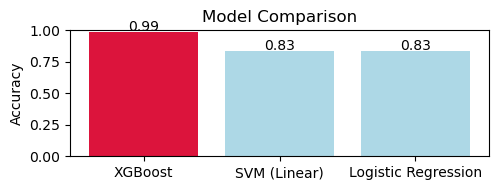

In [27]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(5, 2))

plt.bar(
    model_names,
    accuracies,
    color=["crimson", "lightblue", "lightblue"]
)

plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Model Comparison")

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha="center")

plt.tight_layout()
plt.show()


C:\Users\damia\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


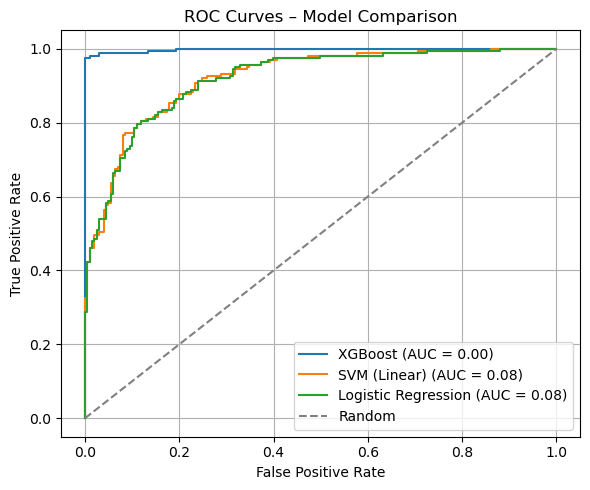

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score, recall_score
import numpy as np

results = {}

plt.figure(figsize=(6, 5))

for name, model in models.items():
    model.fit(X_train, y_train)

    # Probabilidades
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 0]  # probabilidad de Cancer (0)
    else:
        # Para SVM si no hubiese predict_proba (por seguridad)
        scores = model.decision_function(X_test)
        y_prob = -scores  # invertir para que valores altos = Cancer

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=0)
    auc = roc_auc_score(y_test, y_prob)

    # Sensibilidad (Recall Cancer)
    y_pred = model.predict(X_test)
    sensitivity = recall_score(y_test, y_pred, pos_label=0)

    results[name] = {
        "AUC": auc,
        "Sensitivity": sensitivity
    }

    # Plot ROC
    plt.plot(
        fpr,
        tpr,
        label=f"{name} (AUC = {auc:.2f})"
    )
    
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Model Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.rename_axis("Model")

print(metrics_df)

                          AUC  Sensitivity
Model                                     
XGBoost              0.002259     0.975460
SVM (Linear)         0.078961     0.846626
Logistic Regression  0.081159     0.865031
